In [1]:
import tensorflow as tf
from tensorflow.keras import layers as tl
from tensorflow.data import Dataset
import tensorflow_datasets as tfds
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ds_tuple, ds_info = tfds.load(
    'fashion_mnist',
    split=['train[:90%]', 'train[90%:]', 'test'],
    as_supervised=True,  # returns `(img, label)` instead of dict(image=, ...)
    with_info=True,
)

print(ds_info)

train_ds_origin, valid_ds_origin, test_ds_origin = ds_tuple

def preprocess_ds(ds, shuffle=False, seed=42):
    ds = ds.map(lambda X, y: (tf.cast(X, tf.float32) / 255, tf.cast(X, tf.float32) / 255))
    if shuffle:
        ds = ds.shuffle(50_000, seed=seed)

    ds = ds.batch(128).prefetch(1)

    return ds
    


train_ds = preprocess_ds(train_ds_origin)
valid_ds = preprocess_ds(valid_ds_origin)
test_ds = preprocess_ds(test_ds_origin)



tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='/Users/yunhongmin/tensorflow_datasets/fashion_mnist/3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
     

2023-12-06 19:43:29.576722: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-06 19:43:29.576747: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-06 19:43:29.576750: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-06 19:43:29.576779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-06 19:43:29.576797: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
tf.random.set_seed(42)

class Sampling(tl.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2.) + mean


codings_size = 10

inputs = tl.Input(shape=[28, 28])
Z = tl.Flatten()(inputs)
Z = tl.Dense(150, activation='relu')(Z)
Z = tl.Dense(100, activation='relu')(Z)
codings_mean = tl.Dense(codings_size)(Z) # mean
codings_log_var = tl.Dense(codings_size)(Z) # log variance
codings = Sampling()([codings_mean, codings_log_var])

encoder = tf.keras.Model(
    inputs=[inputs],
    outputs=[codings_mean, codings_log_var, codings]
)



In [4]:
decoder_inputs = tl.Input(shape=[codings_size])
x = tl.Dense(100, activation='relu')(decoder_inputs)
x = tl.Dense(150, activation='relu')(x)
x = tl.Dense(28 * 28)(x)
outputs = tl.Reshape([28, 28])(x)
decoder = tf.keras.Model(
    inputs=[decoder_inputs],
    outputs=[outputs]
)



In [5]:
_, _, codings = encoder(inputs)
reconstructions = decoder(codings)
auto_encoder = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])
latent_loss = -0.5 * tf.reduce_sum(1. + codings_log_var - tf.exp(codings_log_var)- tf.square(codings_mean), axis=-1)
latent_loss_for_batch = tf.reduce_mean(latent_loss) / 784.
auto_encoder.add_loss(latent_loss_for_batch)
optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.001, clipvalue=5.0)
auto_encoder.compile(loss='mse', optimizer=optimizer)

In [6]:

skip = True

if not skip:
    history = auto_encoder.fit(train_ds, epochs=25, validation_data=(valid_ds))

In [7]:
codings_size = 10
codings = tf.random.normal(shape=[3 * 7, codings_size])
print(codings_size)
images = decoder.predict(codings)
images = np.clip(images, 0, 1)

10
1/1 [==============================] - 0s 50ms/step


2023-12-06 19:43:29.935177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


<Figure size 640x480 with 0 Axes>

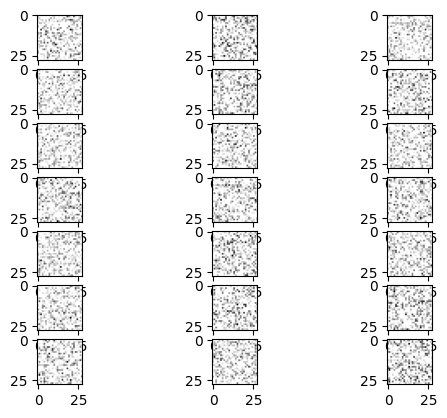

In [8]:
plt.figure()
f, ax = plt.subplots(7, 3)
ax = ax.flatten()

for i in range(21):
    ax[i].imshow(images[i], cmap='binary')

plt.show()


In [9]:
# GAN

codings_size = 30

generator = tf.keras.Sequential([
    tl.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tl.Dense(150, activation='relu', kernel_initializer='he_normal'),
    tl.Dense(28 * 28, activation="sigmoid"),
    tl.Reshape([28, 28])
])

discriminator = tf.keras.Sequential([
    tl.Flatten(),
    tl.Dense(150, activation='relu', kernel_initializer='he_normal'),
    tl.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tl.Dense(1, activation='sigmoid')
])

gan = tf.keras.Sequential([generator, discriminator])

discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [10]:
# 추가 코드 - 패션 MNIST 데이터셋 로드, 스케일링 및 분할
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
train_data_length = len(X_train)
valid_data_length = len(X_valid)
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [11]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [12]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [13]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    for epoch in range(n_epochs):
        print(f'epoch {epoch + 1}/{n_epochs}')
        count = 0
        max_count = train_data_length // batch_size
        for X_batch in dataset:
            # 1. train discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)
            # 2. train generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
            count += 1
            print(f'{count}/{max_count}...', end='')
            print('\r', end='')
        plot_multiple_images(generated_images.numpy(), 8)
        plt.show()




In [14]:
skip = True

if not skip:
    train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

In [15]:
codings_size = 100

generator = tf.keras.Sequential([
    tl.Dense(7*7*128),
    tl.Reshape([7, 7, 128]),
    tl.BatchNormalization(),
    tl.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', activation='relu'),
    tl.BatchNormalization(),
    tl.Conv2DTranspose(1, kernel_size=5, strides=2,
                       padding='same', activation='tanh')
])

discriminator = tf.keras.Sequential([
    tl.Conv2D(64, kernel_size=5, strides=2, padding='same', activation=tl.LeakyReLU(0.2)),
    tl.Dropout(0.4),
    tl.Conv2D(64, kernel_size=5, strides=2, padding='same', activation=tl.LeakyReLU(0.2)),
    tl.Dropout(0.4),
    tl.Flatten(),
    tl.Dense(1, activation='sigmoid')
])

gan_cnn = tf.keras.Sequential([generator, discriminator])

In [16]:
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [17]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable=False
gan_cnn.compile(loss='binary_crossentropy', optimizer='rmsprop')

epoch 1/10


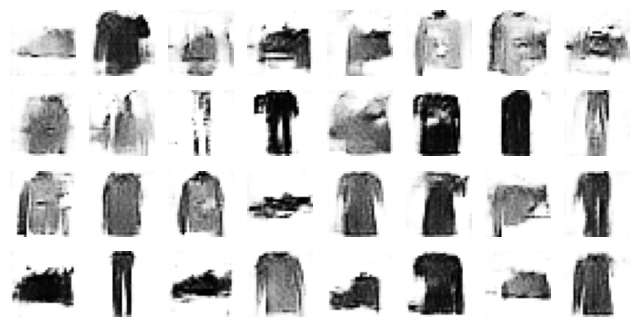

epoch 2/10


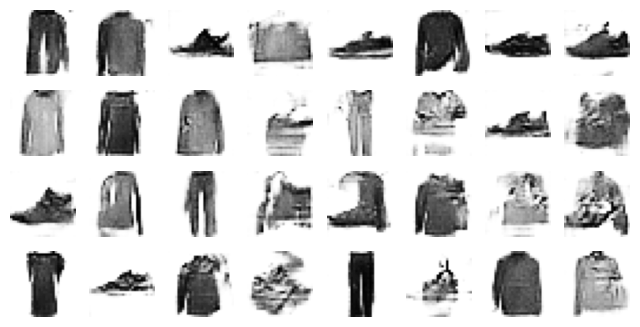

epoch 3/10


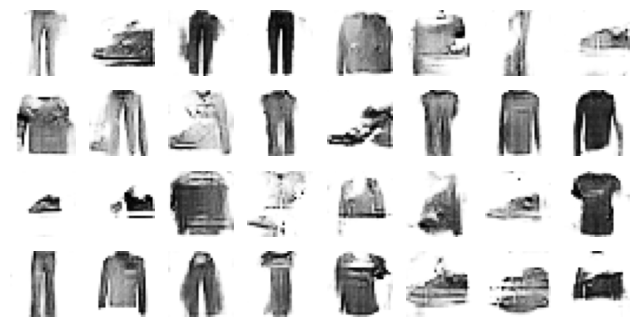

epoch 4/10


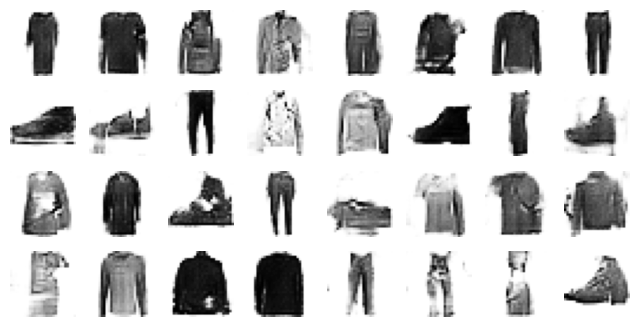

epoch 5/10


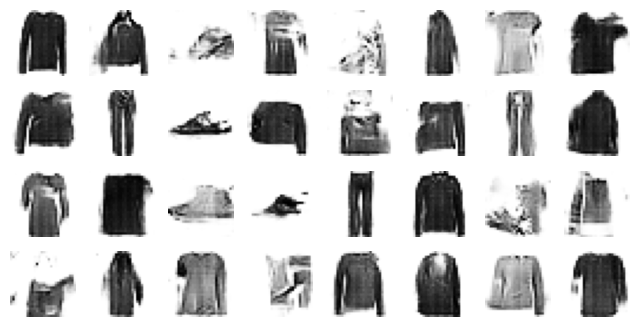

epoch 6/10


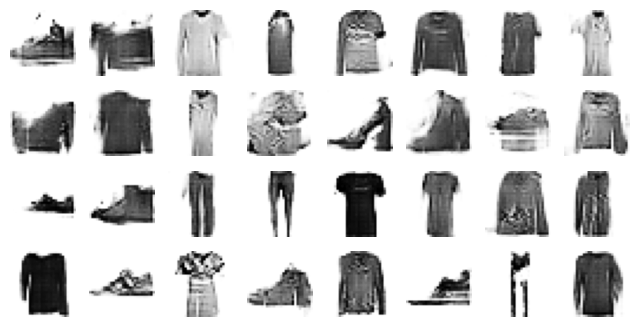

epoch 7/10


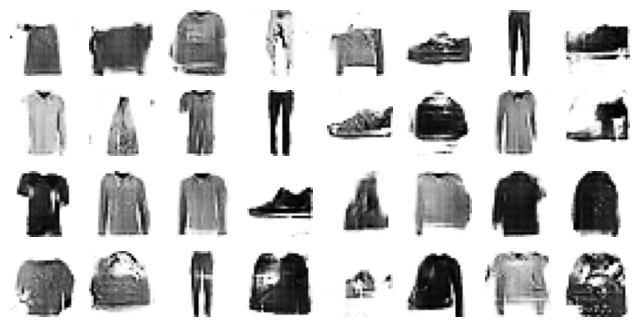

epoch 8/10


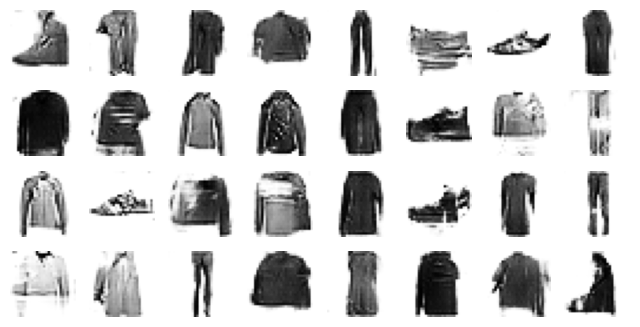

epoch 9/10


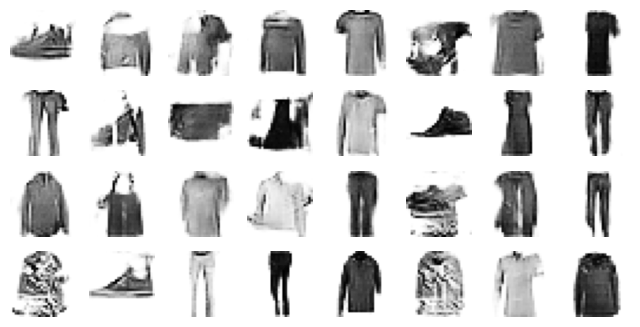

epoch 10/10


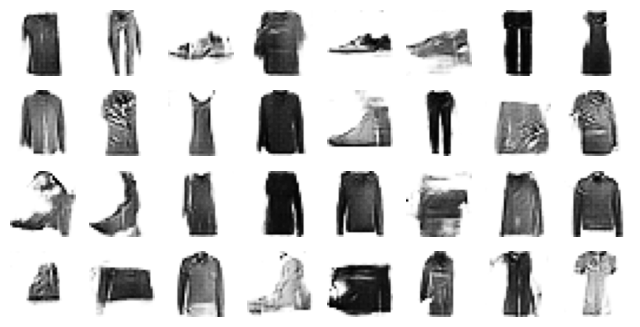

In [19]:
tf.random.set_seed(42)
with tf.device('/cpu:0'):
    train_gan(gan_cnn, dataset, batch_size, codings_size, n_epochs=10)